In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e .
!pip install -e .[notebooks]

Cloning into 'sam3'...
remote: Enumerating objects: 578, done.
remote: Total 578 (delta 0), reused 0 (delta 0), pack-reused 578 (from 1)
Receiving objects: 100% (578/578), 58.92 MiB | 12.43 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 102.9 MB/s eta 0:00:00
  Building editable for sam3 (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-0.editable-py3-none-any.whl size=15197 sha256=

Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.2/143.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.8/515.8 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB

In [20]:
!pip install pyefd

In [1]:
import sys
sys.path.append('/content/sam3')

In [10]:
import torch
#################################### For Image ####################################
from PIL import Image
import sam3
from sam3 import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor
# Load the model
model = build_sam3_image_model()
processor = Sam3Processor(model)
# Load an image



FileNotFoundError: [Errno 2] No such file or directory: 'images/image7.jpg'

In [25]:
def get_masks(path):
  image = Image.open(path)
  inference_state = processor.set_image(image)
  # Prompt the model with text
  output = processor.set_text_prompt(state=inference_state, prompt="humans")
  # Get the masks, bounding boxes, and scores
  return image, output["masks"].cpu().numpy()

In [45]:
import numpy as np
import matplotlib.pyplot as plt
def show_masks(image, masks):
  l = []
  for mask in masks:
    label3 = np.stack([mask[0],mask[0],mask[0]], axis=2)
    l.append(image * label3)
  for i in l:
    plt.imshow(i)
    plt.show()
def show_mask(image, mask):
  label3 = np.stack([mask[0],mask[0],mask[0]], axis=2)
  r = image * label3
  plt.imshow(r)
  plt.show()


In [38]:
# @title

from bz2 import compress
from typing import Any, Callable, Optional

import numpy as np
import torch
from torch import Tensor
from torch import nn as nn
from torchvision.utils import make_grid


FFT_MEASURE_MAX = np.sqrt(np.power(0.5, 2) + np.power(0.5, 2))

def fill_ratio(np_img):

    fill_ratio = np_img.sum().item() / np.ones_like(np_img).sum().item()

    return 1 - fill_ratio, None


def compression_measure(
    np_img,
    fill_ratio_norm=False,
) -> tuple[float, Optional[Tensor]]:

    np_img_bytes = np_img.tobytes()
    compressed = compress(np_img_bytes)

    complexity = len(compressed) / len(np_img_bytes)

    if fill_ratio_norm:
        fill_ratio = np_img.sum().item() / np.ones_like(np_img).sum().item()
        return complexity * (1 - fill_ratio), None

    return complexity, None


def fft_measure(np_img):

    np_img_2d = np_img.squeeze() # Ensure the image is 2D
    fft = np.fft.fft2(np_img_2d)

    fft_abs = np.abs(fft)

    n_h, n_w = fft.shape  # Get both height (n_h) and width (n_w) dimensions

    pos_f_idx_h = n_h // 2
    pos_f_idx_w = n_w // 2

    df_h = np.fft.fftfreq(n=n_h)  # Frequencies for height dimension
    df_w = np.fft.fftfreq(n=n_w)  # Frequencies for width dimension

    # Sum of amplitudes in the positive frequency quadrant
    amplitude_sum = fft_abs[:pos_f_idx_h, :pos_f_idx_w].sum()

    if amplitude_sum == 0:
        return 0.0, None # Avoid division by zero

    # Calculate mean frequencies
    # For x-frequency, broadcast df_w across rows
    mean_x_freq = (fft_abs[:pos_f_idx_h, :pos_f_idx_w] * df_w[:pos_f_idx_w]).sum() / amplitude_sum
    # For y-frequency, broadcast df_h across columns
    mean_y_freq = (fft_abs[:pos_f_idx_h, :pos_f_idx_w].T * df_h[:pos_f_idx_h]).T.sum() / amplitude_sum

    mean_freq = np.sqrt(np.power(mean_x_freq, 2) + np.power(mean_y_freq, 2))

    # mean frequency in range 0 to np.sqrt(0.5^2 + 0.5^2)
    return mean_freq / FFT_MEASURE_MAX, None


def vae_reconstruction_measure(
    img: Tensor,
    model_gb: nn.Module,
    model_lb: nn.Module,
    fill_ratio_norm=False,
) -> tuple[float, Optional[Tensor]]:
    model_gb.eval()
    model_lb.eval()

    with torch.no_grad():
        mask = img.to(model_gb.device)  # type: ignore

        recon_gb: Tensor
        recon_lb: Tensor

        recon_gb, _, _ = model_gb(mask)
        recon_lb, _, _ = model_lb(mask)

        abs_px_diff = (recon_gb - recon_lb).abs().sum().item()

        complexity = abs_px_diff / mask.sum()

        if fill_ratio_norm:
            complexity *= mask.sum().item() / torch.ones_like(mask).sum().item()

        return (
            complexity,
            make_grid(
                torch.stack(
                    [mask[0], recon_gb.view(-1, 64, 64), recon_lb.view(-1, 64, 64)]
                ).cpu(),
                nrow=1,
                padding=0,
            ),
        )


def combined_complexity(mask):
  return (compression_measure(mask)[0] + 0.025*fft_measure(mask)[0])*100

In [33]:
from pyefd import elliptic_fourier_descriptors
import cv2
import numpy as np

# Function to find contours in a binary mask
def find_contours(mask):
    # Ensure the mask is a single-channel binary image (0 or 1)
    processed_mask = np.asarray(mask).squeeze()
    if processed_mask.ndim == 3 and processed_mask.shape[-1] == 3:
        # If it's a 3-channel image, take the first channel
        processed_mask = processed_mask[:, :, 0]
    processed_mask = processed_mask.astype(np.uint8)

    # Find contours in the binary mask
    # Use cv2.RETR_EXTERNAL to retrieve only the outer contours
    # Use cv2.CHAIN_APPROX_SIMPLE to compress horizontal, vertical, and diagonal segments
    contours, _ = cv2.findContours(processed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return []
    # Find the largest contour by area
    largest_contour = max(contours, key=cv2.contourArea)
    return [np.concatenate(contours)] # Return as a list containing only the largest contour

def get_elliptic_fourier_descriptors_complexity(skimage_masks, skimage_masks2):

  # Get contours for the selected masks
  contours1 = []
  contours2 = []
  complexity1 = []
  complexity2 = []

  for mask in skimage_masks:
      l = find_contours(mask)
      complexity1.append(combined_complexity(mask))
      if l:
          # Ensure each contour is a single array of points for simplicity
          contours1.append(l)
  for mask in skimage_masks2:
      l = find_contours(mask)
      complexity2.append(combined_complexity(mask))
      if l:
        contours2.append(l)

  # Check if contours were found
  if contours1 and contours2:
      # Calculate elliptic Fourier descriptors for the found contours
      coeffs1 = []
      coeffs2 = []
      for contour in contours1:

          if len(contour[0].squeeze()) > 2:
            coeffs1.append(elliptic_fourier_descriptors(contour[0].squeeze(), order=5, normalize=True))
      for contour in contours2:
          if len(contour[0].squeeze()) > 2:
            coeffs2.append(elliptic_fourier_descriptors(contour[0].squeeze(), order=5, normalize=True))
  else:
      print("Could not find contours in one or both masks.")

  return coeffs1, coeffs2, complexity1, complexity2

# --- Complexity Calculation ---

In [87]:
# @title
def get_distance(coeffs1, coeffs2, complexity1, complexity2, eomt=False):

  coeffsfiltered1 =[]
  coeffsfiltered2 =[]
  print(complexity1)
  print(complexity2)

  for j in range(len(coeffs1)):
    l = []

    if complexity1[j]>0.74 or eomt:

      for i in coeffs1[j]:

        a = np.array(i)

        a[np.abs(a)>0.11]=0

        l.append(a)
      coeffsfiltered1.append((np.concatenate(l, axis=0), j))
  for j in range(len(coeffs2)):
    l = []

    if complexity2[j]>0.74 or eomt:
      for i in coeffs2[j]:
        a = np.array(i)

        a[np.abs(a)>0.11]=0

        l.append(a)
      coeffsfiltered2.append((np.concatenate(l, axis=0),j))
  if not coeffsfiltered1:
    l=[]
    for i in coeffs1[complexity1.index(max(complexity1))]:
      a = np.array(i)

      a[np.abs(a)>0.11]=0

      l.append(a)
    coeffsfiltered1.append((np.concatenate(l, axis=0), j))
  if not coeffsfiltered2:
    l=[]
    for i in coeffs2[complexity2.index(max(complexity2))]:
      a = np.array(i)

      a[np.abs(a)>0.11]=0

      l.append(a)
    coeffsfiltered2.append((np.concatenate(l, axis=0), j))
  dist = []
  for i in coeffsfiltered1:
    for j in coeffsfiltered2:
      dist.append((np.linalg.norm(i[0]-j[0]),i[1], j[1]))
  print(sorted(dist))
  return sorted(dist)




[1.013532225525085, 0.9461658982538935]
[0.8449982061443579, 1.0622733352323002, 0.923825481602486]
[(0.14882449144035667, 1, 0), (0.18020117782383788, 0, 2), (0.19987164826796736, 1, 2), (0.236840809103705, 0, 0), (0.3144103841701737, 0, 1), (0.344391961653817, 1, 1)]


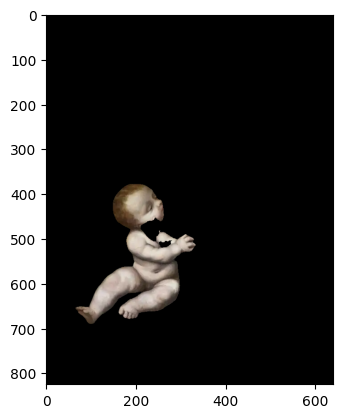

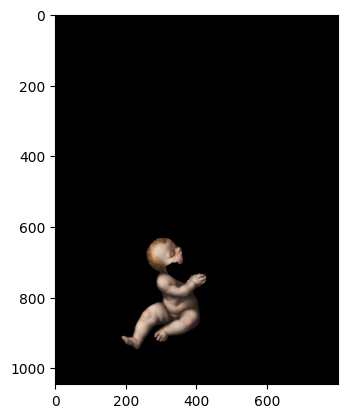

False

In [91]:
from torch._C import ComplexType
def compare_two_images(image1link, image2link, eomt=False):

  image1, masks1 = get_masks(image1link)
  image2, masks2 = get_masks(image2link)


  coeffs1, coeffs2, complexity1, complexity2 = get_elliptic_fourier_descriptors_complexity(masks1, masks2)

  dist = get_distance(coeffs1, coeffs2, complexity1, complexity2, eomt)
  if dist :


    show_mask(image1, masks1[dist[0][1]])
    show_mask(image2, masks2[dist[0][2]])
    if dist[0][0]<0.1:
      return True
  return False

compare_two_images("images/image7.jpg", "images/image8.jpg")